In [3]:
import gzip
import numpy as np
import array
import math
import numba as nb
from numba.typed import List
import matplotlib.pyplot as plt

# 1. Naive Bayes classifier

In [12]:
training_image_list = List()
training_label_list = List()
# Load the training dataset
with gzip.open('/content/train-images-idx3-ubyte.gz', 'r') as f:
    magic_number = f.read(4) #magic number
    num_images_training = f.read(4) #number of images
    num_images_training = int.from_bytes(num_images_training, byteorder='big') #change char to integer

    num_rows = f.read(4) #number of rows
    num_rows = int.from_bytes(num_rows, byteorder='big') #change char to integer

    num_columns = f.read(4) #number of columns
    num_columns = int.from_bytes(num_columns, byteorder='big') #change char to integer
    for i in range(num_images_training):
        image = f.read(num_rows * num_columns)
        image = array.array('B', image)
        training_image_list.append(image)

image_size = num_rows * num_columns

# Load the training labels
with gzip.open('/content/train-labels-idx1-ubyte.gz', 'r') as f:
    magic_number = f.read(4) #magic number
    num_labels_training = f.read(4) #number of labels
    num_labels_training = int.from_bytes(num_labels_training, byteorder='big') #change char to integer

    for i in range(num_labels_training):
        label = f.read(1)
        label = int.from_bytes(label, byteorder='big') #change char to integer
        training_label_list.append(label)

testing_image_list = List()
testing_label_list = List()

# Load the testing image
with gzip.open('/content/t10k-images-idx3-ubyte.gz', 'r') as f:
    magic_number = f.read(4) #magic number
    num_images_test = f.read(4) #number of images
    num_images_test = int.from_bytes(num_images_test, byteorder='big') #change char to integer

    num_rows = f.read(4) #number of rows
    num_rows = int.from_bytes(num_rows, byteorder='big') #change char to integer

    num_columns = f.read(4) #number of columns
    num_columns = int.from_bytes(num_columns, byteorder='big') #change char to integer
    for i in range(num_images_test):
        image = f.read(num_rows*num_columns)
        image = array.array('B', image)
        testing_image_list.append(image)

# Load the testing labels
with gzip.open('/content/t10k-labels-idx1-ubyte.gz', 'r') as f:
    magic_number = f.read(4) #magic number
    num_labels_testing = f.read(4) #number of labels
    num_labels_testing = int.from_bytes(num_labels_testing, byteorder='big') #change char to integer

    for i in range(num_labels_testing):
        label = f.read(1)
        label = int.from_bytes(label, byteorder='big') #change char to integer
        testing_label_list.append(label)



In [13]:
def write_result(postirior,likelihood, mode, flie_name):
    with open(flie_name, 'w') as file:
        error_count = 0.0
        for i in range(num_images_test):
            file.write("Postirior (in log scale):\n")
            for j in range(10):
                file.write(f"{j}: {postirior[i][j]/np.sum(postirior[i])}\n")
            if(np.argmax(postirior[i])!= testing_label_list[i]):
                error_count += 1
            file.write(f"Prediction: {np.argmax(postirior[i])}, Ans: {testing_label_list[i]}\n\n")

        file.write("Imagination of numbers in Bayesian classifier:")
        for i in range(10):
            file.write(f"{i}:\n")
            image_data = np.zeros((28,28))
            for j in range(28):
                for k in range(28):
                    if(mode=='0'):
                        file.write(f"{0 if np.argmax(likelihood[i][28*j+k]) <= 16 else 1}")
                    else:
                        file.write(f"{0 if likelihood[i][28*j+k][0] < 128 else 1}")
                file.write("\n")
            file.write("\n")
        file.write(f"\nError rate: {error_count/num_images_test}")

@nb.njit()
def discrete_classifier(training_image_list, training_label_list, testing_image_list, testing_label_list):
    #pre-processing images
    frequency_train = np.zeros((num_images_training, image_size))
    for i in range(num_images_training):
        for j in range(image_size):
            frequency_train[i][j] = training_image_list[i][j]//8

    log_Prior = [] # P(labels = {0,1,2,...,9})
    for i in range(10):
        log_Prior.append(math.log(training_label_list.count(i)/num_labels_training))

    likelihood = np.zeros((10, image_size, 32))
    for i in range(num_images_training):
        for j in range(image_size):
            likelihood[training_label_list[i]][j][int(frequency_train[i][j])] += 1

    for i in range(likelihood.shape[0]):
        for j in range(likelihood.shape[1]):
            likelihood[i][j][:] = likelihood[i][j]/np.sum(likelihood[i][j])
            min = np.min(likelihood[i][j][likelihood[i][j]!=0])
            zeros = np.where(likelihood[i][j]==0)[0]
            for index in zeros:
                likelihood[i][j][index] = min

    #get test
    frequency_test = np.zeros((num_images_test, image_size))
    for i in range(num_images_test):
        for j in range(image_size):
            frequency_test[i][j] = testing_image_list[i][j]//8

    posterior = np.zeros((num_images_test, 10))

    for i in range(num_images_test):
        for j in range(10):
            for k in range(image_size):
                if likelihood[j][k][int(frequency_test[i][k])]!=0:
                    posterior[i][j] += math.log(likelihood[j][k][int(frequency_test[i][k])])
                else:
                    posterior[i][j] += math.log(np.min(likelihood[j][k][likelihood[j][k]!=0]))
            posterior[i][j] += log_Prior[j]
    return posterior,likelihood

@nb.njit()
def continuous__classifier(training_image_list, training_label_list, testing_image_list, testing_label_list):
    Prior = np.zeros((10)) # P(labels = {0,1,2,...,9})
    Gaussian = np.zeros((10,image_size,2)) #2->mean,var

    #use sequential learning to compute mean var
    for i in range(num_images_training):
        for j in range(image_size):
            Gaussian[training_label_list[i]][j][0] = (Prior[training_label_list[i]]*Gaussian[training_label_list[i]][j][0]+training_image_list[i][j])/(Prior[training_label_list[i]]+1)
            Gaussian[training_label_list[i]][j][1] = (Prior[training_label_list[i]]*Gaussian[training_label_list[i]][j][1]+training_image_list[i][j]**2)/(Prior[training_label_list[i]]+1)
        Prior[training_label_list[i]] += 1
    for i in range(10):
        for j in range(image_size):
            Gaussian[i][j][1] -= Gaussian[i][j][0]**2

    Prior = Prior/num_images_training

    posterior = np.zeros((num_images_test, 10))
    for i in range(num_images_test):
        for j in range(10):
            posterior[i][j] += math.log(Prior[j])
            for k in range(image_size):
                if Gaussian[j][k][1]!=0:
                    posterior[i][j] -= (1/2)*math.log(2*math.pi)
                    posterior[i][j] -= math.log(math.sqrt(Gaussian[j][k][1]))
                    posterior[i][j] -= ((testing_image_list[i][k]-Gaussian[j][k][0])**2)/(Gaussian[j][k][1])
    return posterior,Gaussian



In [15]:
options = input('Eneter mode(0:discrete, 1:continuous): ')
if(options == '0'):
    posterior,likelihood = discrete_classifier(training_image_list, training_label_list, testing_image_list, testing_label_list)
    write_result(posterior,likelihood,options,'discrete_output.txt')
else:
    posterior,likelihood = continuous__classifier(training_image_list, training_label_list, testing_image_list, testing_label_list)
    write_result(posterior,likelihood,options,'continuous_output.txt')

Eneter mode(0:discrete, 1:continuous): 1


# 2. Online Learning

Enter parameter a for the initial beta prior: 0
Enter parameter b for the initial beta prior: 0

case 1: 0101010101001011010101
Likelihood: 0.16818809509277344
Beta prior:   a = 0, b = 0
Beta posterior: a = 11, b = 11

case 2: 0110101
Likelihood: 0.29375515303997485
Beta prior:   a = 11, b = 11
Beta posterior: a = 15, b = 14


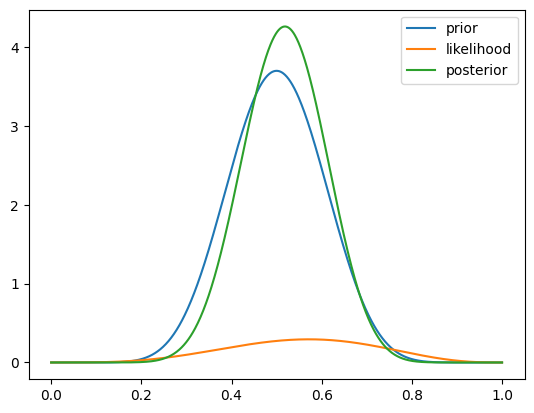


case 3: 010110101101
Likelihood: 0.2286054241794335
Beta prior:   a = 15, b = 14
Beta posterior: a = 22, b = 19


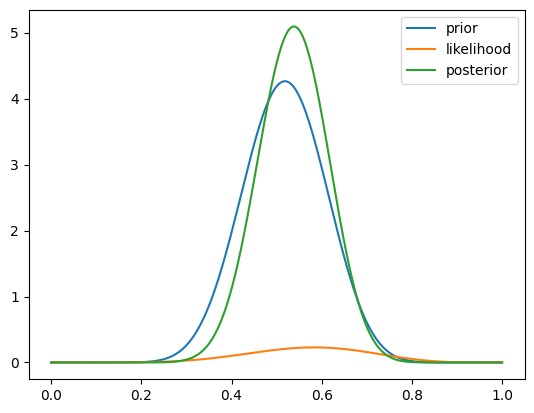


case 4: 0101101011101011010
Likelihood: 0.18286870706509092
Beta prior:   a = 22, b = 19
Beta posterior: a = 33, b = 27


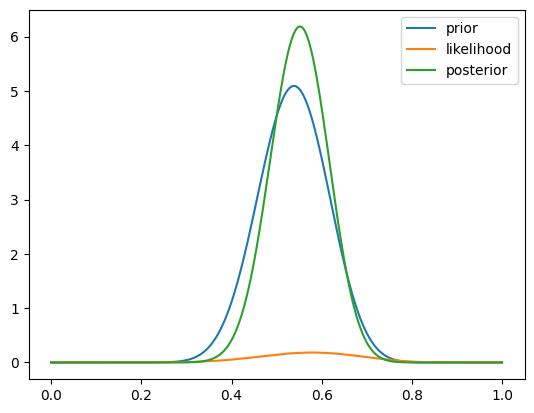


case 5: 111101100011110
Likelihood: 0.2143070548857833
Beta prior:   a = 33, b = 27
Beta posterior: a = 43, b = 32


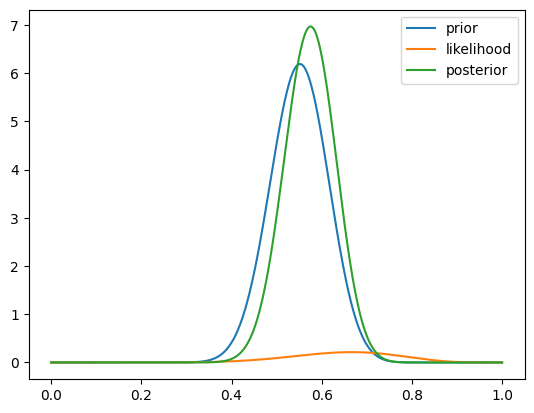


case 6: 101110111000110
Likelihood: 0.20659760529408
Beta prior:   a = 43, b = 32
Beta posterior: a = 52, b = 38


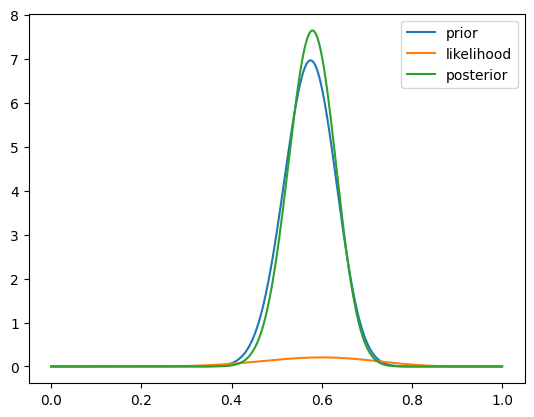


case 7: 1010010111
Likelihood: 0.25082265600000003
Beta prior:   a = 52, b = 38
Beta posterior: a = 58, b = 42


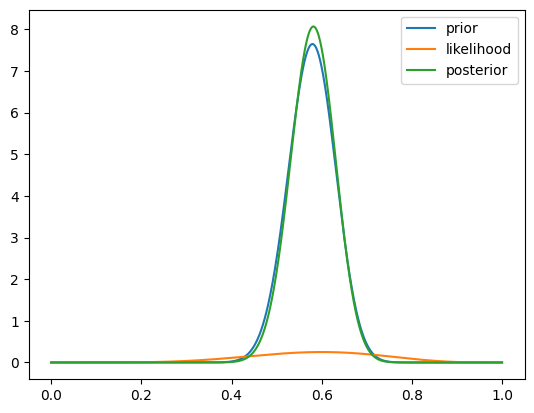


case 8: 11101110110
Likelihood: 0.2619678932864457
Beta prior:   a = 58, b = 42
Beta posterior: a = 66, b = 45


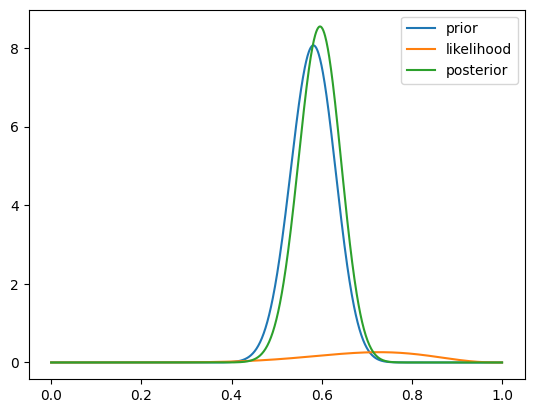


case 9: 01000111101
Likelihood: 0.23609128871506807
Beta prior:   a = 66, b = 45
Beta posterior: a = 72, b = 50


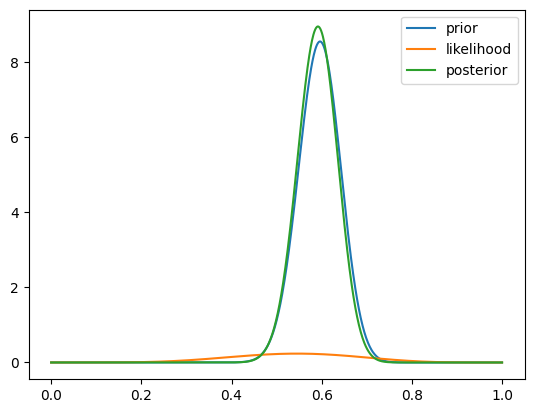


case 10: 110100111
Likelihood: 0.27312909617436365
Beta prior:   a = 72, b = 50
Beta posterior: a = 78, b = 53


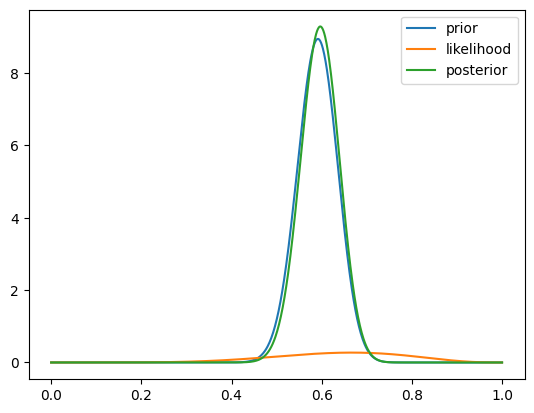


case 11: 01101010111
Likelihood: 0.24384881449471862
Beta prior:   a = 78, b = 53
Beta posterior: a = 85, b = 57


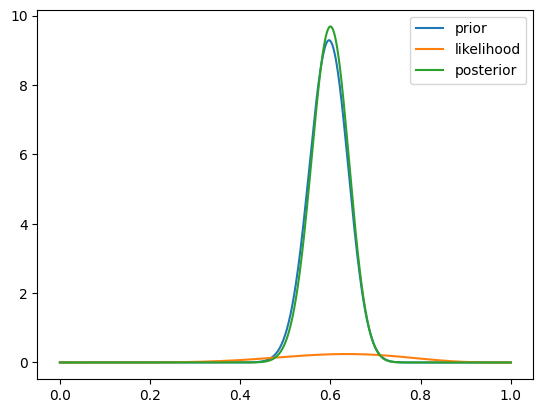

In [16]:
def conjugation(prior_a, prior_b, experiments):
    m = experiments.count('1')
    N = len(experiments)
    max_likelihood = m/N
    return math.comb(N, m) * (max_likelihood**m) * ((1-max_likelihood)**(N-m)), prior_a+m, prior_b+N-m ,m, N-m

Cases = []

a = int(input("Enter parameter a for the initial beta prior: "))
b = int(input("Enter parameter b for the initial beta prior: "))

with open('/content/testfile', 'r') as file:
    lines = file.readlines()
    for line in lines:
        Cases.append(line.strip())

for i in range(len(Cases)):
    likelihood, a_posterior, b_posterior, count_1, count_0 = conjugation(a,b,Cases[i])
    print(f"\ncase {i+1}: {Cases[i]}")
    print(f"Likelihood: {likelihood}")
    print(f"Beta prior:   a = {a}, b = {b}")
    print(f"Beta posterior: a = {a_posterior}, b = {b_posterior}")

    import matplotlib.pyplot as plt
    import numpy as np

    # 生成数据
    if a*b > 0:
        x = np.linspace(0, 1, 1000)
        c = math.factorial(a + b - 1)/(math.factorial(a - 1) * math.factorial(b - 1))
        Y_prior = c * (x ** (a - 1)) * ((1 - x) ** (b - 1))

        c = math.factorial(count_0 + count_1)/(math.factorial(count_0) * math.factorial(count_1))
        Y_likelihood = c * (x ** (count_1)) * ((1 - x) ** (count_0))

        c = math.factorial(a_posterior + b_posterior - 1)/(math.factorial(a_posterior - 1) * math.factorial(b_posterior - 1))
        y_posterior = c * (x ** (a_posterior - 1)) * ((1 - x) ** (b_posterior - 1))

        # 创建画布和轴对象
        fig, ax = plt.subplots()

        # 绘制三条曲线
        ax.plot(x, Y_prior, label = 'prior')
        ax.plot(x, Y_likelihood, label = 'likelihood')
        ax.plot(x, y_posterior, label = 'posterior')

        # 添加图例
        ax.legend()
        # 显示图形
        plt.show()

    a = a_posterior
    b = b_posterior
